# Brightfield-Brightfield Data Preparation

- Fixed image: MD589
- Moving image: MD594

In [1]:
from pathlib import Path

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform

import utility as util

In [2]:
ratto_pipeline_data_dir = Path('/net/birdstore/Active_Atlas_Data/data_root/pipeline_data')

## Load image stacks

In [3]:
def load_image_stack(image_dir, channel=1):
    image_dir = Path(image_dir).resolve()
    image_stack = []
    for image_file in sorted(image_dir.iterdir()):
        print(f'Loading image {image_file.name}', end='\r')
        image = sitk.ReadImage(image_file.as_posix())
        image_arr = sitk.GetArrayViewFromImage(image).copy()
        image_stack.append(image_arr[:,:,channel-1].T)
    print(f'Finished loading {len(image_stack)} images')
    image_stack = np.stack(image_stack, axis=-1)
    return image_stack

Finished loading 447 images
(1365, 1012, 447)


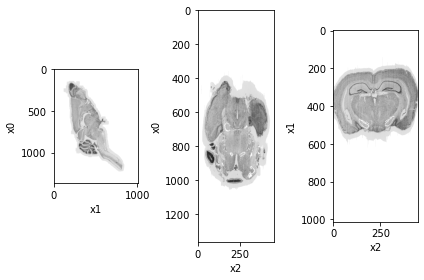

In [4]:
fixed_image = load_image_stack(ratto_pipeline_data_dir / 'MD589/preps/CH1/thumbnail_aligned')
print(fixed_image.shape)
util.imshow_midslice(fixed_image)

Finished loading 433 images
(1468, 728, 433)


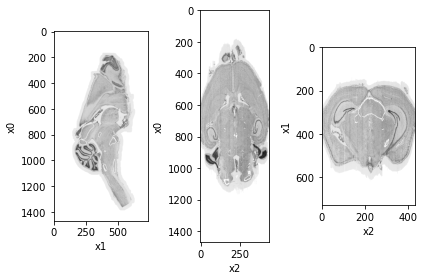

In [5]:
moving_image = load_image_stack(ratto_pipeline_data_dir / 'MD594/preps/CH1/thumbnail_aligned')
print(moving_image.shape)
util.imshow_midslice(moving_image)

## Downsample images

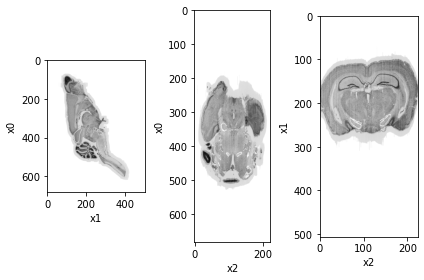

In [6]:
fixed_image = skimage.transform.rescale(fixed_image, [0.5, 0.5, 0.5])
util.imshow_midslice(fixed_image)

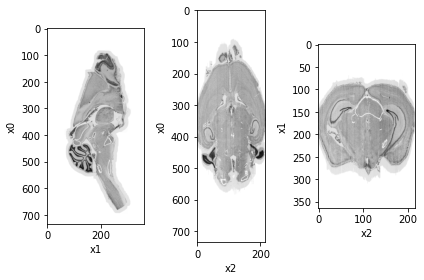

In [7]:
moving_image = skimage.transform.rescale(moving_image, [0.5, 0.5, 0.5])
util.imshow_midslice(moving_image)

## Scale intensity range

In [8]:
def scale_intensity(image):
    v_min, v_max = image.min(), image.max()
    return (image - v_min) / (v_max - v_min)

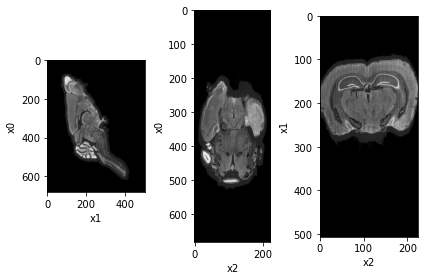

In [9]:
fixed_image = 1 - scale_intensity(fixed_image)
util.imshow_midslice(fixed_image)

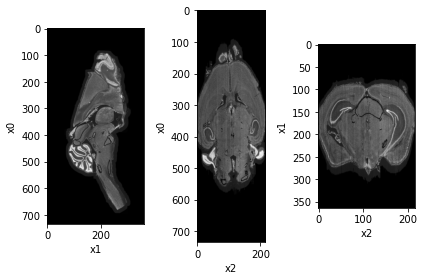

In [10]:
moving_image = 1 - scale_intensity(moving_image)
util.imshow_midslice(moving_image)

## Crop images

In [11]:
def crop(image, crop_value=1e-3):
    xi = 0
    for xi in range(image.shape[0]):
        if not (image[xi,:,:] <  crop_value).all():
            break
    xj = image.shape[0]
    for xj in reversed(range(image.shape[0])):
        if not (image[xj,:,:] < crop_value).all():
            xj += 1
            break
    yi = 0
    for yi in range(image.shape[1]):
        if not (image[:,yi,:] <  crop_value).all():
            break
    yj = image.shape[1]
    for yj in reversed(range(image.shape[1])):
        if not (image[:,yj,:] < crop_value).all():
            yj += 1
            break
    zi = 0
    for zi in range(image.shape[2]):
        if not (image[:,:,zi] <  crop_value).all():
            break
    zj = image.shape[2]
    for zj in reversed(range(image.shape[2])):
        if not (image[:,:,zj] < crop_value).all():
            zj += 1
            break
    return image[xi:xj,yi:yj,zi:zj]

(579, 386, 224)


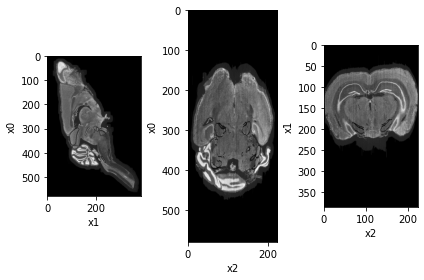

In [12]:
fixed_image = crop(fixed_image)
print(fixed_image.shape)
util.imshow_midslice(fixed_image)

(625, 263, 216)


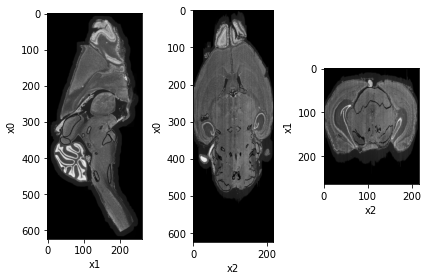

In [13]:
moving_image = crop(moving_image)
print(moving_image.shape)
util.imshow_midslice(moving_image)

## Pad images to be the same shape

In [14]:
def pad(images):
    shape = np.array(list(map(lambda image: image.shape, images))).max(axis=0)

    def put_in_the_middle(canvas, image):
        dx, dy, dz = image.shape
        x, y, z = (np.array(canvas.shape) - np.array(image.shape)) // 2
        canvas[x:x+dx,y:y+dy,z:z+dz] = image
        
    padded_images = []
    for image in images:
        canvas = np.zeros(shape, dtype=image.dtype)
        put_in_the_middle(canvas, image)
        padded_images.append(canvas)
    return padded_images

In [15]:
fixed_image, moving_image = pad([fixed_image, moving_image])
print(fixed_image.shape)
print(moving_image.shape)

(625, 386, 224)
(625, 386, 224)


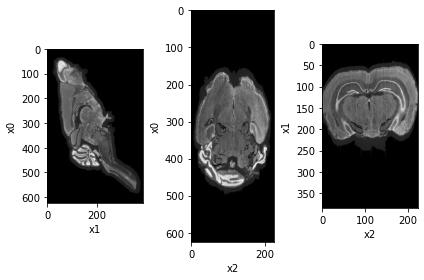

In [16]:
util.imshow_midslice(fixed_image)

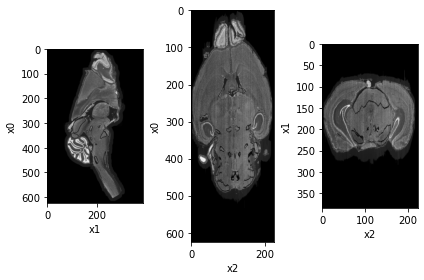

In [17]:
util.imshow_midslice(moving_image)

## Save image to npy file

In [18]:
!mkdir -p ../data/bb

In [19]:
np.save('../data/bb/fixed_image.npy', fixed_image)

In [20]:
np.save('../data/bb/moving_image.npy', moving_image)